<a href="https://colab.research.google.com/github/jjjung99/SD-design/blob/main/%EB%B0%94%EC%9D%B8%EB%94%A9%EC%97%90%EB%84%88%EC%A7%80_%EC%B6%94%EC%A0%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[INFO] Loaded chromosomes: ['NC_000913.3']
[INFO] Total features in GFF: 9523
[INFO] ASD candidates (from 16S rRNA 3' ends, DNA):
  ASD1: CACCTCCTTA
  ASD2: CACCTCCTTA
  ASD3: CACCTCCTTA
  ASD4: CACCTCCTTA
  ASD5: CACCTCCTTA
  ASD6: CACCTCCTTA
  ASD7: CACCTCCTTA

[INFO] Using WT_ASD_RNA = CACCUCCUUA for ΔG calculation

[INFO] Total CDS in genome      : 4340
[INFO] Genes with SD candidates : 4101

=== MG1655 WT SD–WT ASD Binding Energy Distribution ===
Count   : 4101
Mean    : -5.710 kcal/mol
Median  : -5.800 kcal/mol
Std     : 1.968 kcal/mol
25%     : -6.900 kcal/mol
75%     : -4.100 kcal/mol
Min/Max : -10.200 / -0.900 kcal/mol


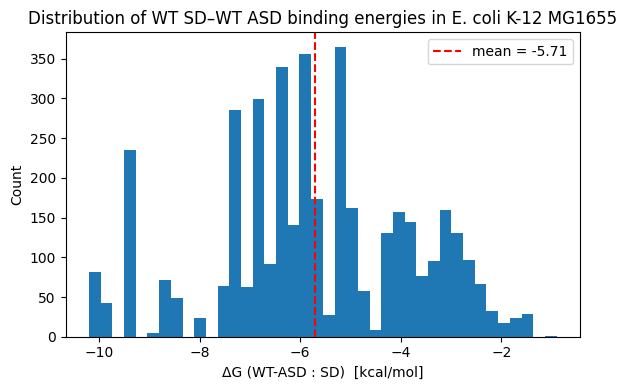


=== Suggested TARGET_DG for orthogonal SD design ===
TARGET_DG (mean WT SD–ASD) = -5.710 kcal/mol
Recommended ΔG range       = [-6.110, -5.310] kcal/mol


In [12]:
# ============================
# MG1655 WT SD–ASD ΔG 분석 + TARGET_DG 계산 
# ============================

# 1) ViennaRNA, Biopython 설치
!apt-get -y install viennarna > /dev/null 2>&1
!pip install -q biopython

# 2) import
import RNA
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np

# 3) 파일 경로 
genome_fasta_path = "/GCF_000005845.2_ASM584v2_genomic.fna"
gff_path          = "/genomic.gff"

# ----------------------------
# 유틸 함수들
# ----------------------------
def dna_to_rna(seq: str) -> str:
    """DNA -> RNA (T -> U)"""
    return seq.upper().replace("T", "U")

def revcomp_dna(seq: str) -> str:
    """DNA 역상보 서열"""
    comp = str.maketrans("ACGTacgt", "TGCAtgca")
    return seq.translate(comp)[::-1]

def is_sd_candidate(motif: str) -> bool:
    """
    SD 후보 필터 
    - 길이 4~6
    - A/G 비율 >= 60%
    - 최소 한 번 이상 'GG' 또는 'AGG' 또는 'GAG' 포함
    """
    motif = motif.upper().replace("U", "T")
    L = len(motif)
    if L < 4 or L > 6:
        return False
    purines = motif.count("A") + motif.count("G")
    if purines < int(0.6 * L):
        return False
    if ("GG" not in motif) and ("AGG" not in motif) and ("GAG" not in motif):
        return False
    return True

# ----------------------------
# FASTA / GFF 로딩
# ----------------------------
# genome 시퀀스 로드
genome_dict = {}
for record in SeqIO.parse(genome_fasta_path, "fasta"):
    genome_dict[record.id] = str(record.seq).upper()

# GFF feature 로드
features = []  # (seqid, ftype, start, end, strand, attrs)
with open(gff_path, "r") as gff:
    for line in gff:
        if not line.strip() or line.startswith("#"):
            continue
        cols = line.rstrip().split("\t")
        if len(cols) != 9:
            continue
        seqid, source, ftype, start, end, score, strand, phase, attrs = cols
        features.append((seqid, ftype, int(start), int(end), strand, attrs))

print(f"[INFO] Loaded chromosomes: {list(genome_dict.keys())}")
print(f"[INFO] Total features in GFF: {len(features)}")

# ----------------------------
# 16S rRNA에서 WT-ASD 자동 추출
# ----------------------------
ASD_list = []

for seqid, ftype, start, end, strand, attrs in features:
    if ftype == "rRNA" and "16S ribosomal RNA" in attrs:
        if seqid not in genome_dict:
            continue
        full_rrna = genome_dict[seqid][start-1:end]  # DNA
        if strand == "-":
            full_rrna = revcomp_dna(full_rrna)
        # 3' 말단 10nt를 ASD로 사용 
        asd_dna = full_rrna[-10:]
        ASD_list.append(asd_dna)

if not ASD_list:
    raise RuntimeError("16S rRNA에서 ASD를 찾지 못했음. GFF 내용을 확인하세요.")

print("[INFO] ASD candidates (from 16S rRNA 3' ends, DNA):")
for idx, asd in enumerate(ASD_list, 1):
    print(f"  ASD{idx}: {asd}")

# 여러 copy가 있더라도 보통 서열이 동일하므로 첫 번째를 사용
WT_ASD_DNA = ASD_list[0]
WT_ASD_RNA = dna_to_rna(WT_ASD_DNA)
print(f"\n[INFO] Using WT_ASD_RNA = {WT_ASD_RNA} for ΔG calculation")

# ----------------------------
# CDS upstream 20nt 추출 함수
# ----------------------------
def get_upstream_20(seqid: str, start: int, end: int, strand: str, window: int = 20):
    """CDS 기준 mRNA upstream 20nt (DNA) 반환. 범위 안되면 None."""
    if seqid not in genome_dict:
        return None
    chrom = genome_dict[seqid]
    L = len(chrom)

    if strand == "+":
        s0 = start - 1  # 0-based
        if s0 < window:
            return None
        return chrom[s0-window:s0].upper()
    elif strand == "-":
        e0 = end - 1
        if e0 + window >= L:
            return None
        downstream = chrom[e0+1:e0+1+window]  # genomic에서 CDS 뒤쪽 20nt
        return revcomp_dna(downstream).upper()
    else:
        return None

# ----------------------------
# upstream window에서 SD motif 찾기
# ----------------------------
def find_sd_motifs(window: str):
    """upstream window(20nt) 안에서 4~6mer sliding window로 SD 후보 추출"""
    window = window.upper()
    motifs = []
    for k in [4, 5, 6]:
        for i in range(0, len(window) - k + 1):
            m = window[i:i+k]
            if is_sd_candidate(m):
                motifs.append(m)
    return motifs

# ----------------------------
# WT-ASD – SD ΔG 계산 함수
# ----------------------------
def calc_binding_energy(sd_dna: str) -> float:
    """WT ASD와 SD(DNA)의 duplex ΔG 계산 (kcal/mol)"""
    sd_rna = dna_to_rna(sd_dna)
    duplex = RNA.duplexfold(WT_ASD_RNA, sd_rna)
    return duplex.energy

# ----------------------------
# 전체 CDS에 대해:
#   1) upstream 20nt 추출
#   2) SD motif 후보 찾기
#   3) gene 당 가장 강하게 결합하는 motif 1개 선택
#   4) 그 ΔG만 저장
# ----------------------------
energies = []
motif_records = []  # (seqid, start, strand, best_motif, best_dG)

cds_count = 0
for seqid, ftype, start, end, strand, attrs in features:
    if ftype != "CDS":
        continue
    cds_count += 1

    upstream = get_upstream_20(seqid, start, end, strand, window=20)
    if upstream is None:
        continue

    motifs = find_sd_motifs(upstream)
    if not motifs:
        continue

    best_motif = None
    best_dG = None
    for m in motifs:
        dG = calc_binding_energy(m)
        if (best_dG is None) or (dG < best_dG):
            best_dG = dG
            best_motif = m

    if best_motif is not None:
        energies.append(best_dG)
        motif_records.append((seqid, start, strand, best_motif, best_dG))

print(f"\n[INFO] Total CDS in genome      : {cds_count}")
print(f"[INFO] Genes with SD candidates : {len(energies)}")

if not energies:
    raise RuntimeError("어떤 CDS에서도 SD 후보를 찾지 못했습니다. 필터 조건을 확인하세요.")

energies = np.array(energies)

# ----------------------------
# ΔG 분포 통계 + 히스토그램 + TARGET_DG
# ----------------------------
mean_dG   = float(energies.mean())
median_dG = float(np.median(energies))
std_dG    = float(energies.std())
min_dG    = float(energies.min())
max_dG    = float(energies.max())
p25, p75  = np.percentile(energies, [25, 75])

print("\n=== MG1655 WT SD–WT ASD Binding Energy Distribution ===")
print(f"Count   : {len(energies)}")
print(f"Mean    : {mean_dG:.3f} kcal/mol")
print(f"Median  : {median_dG:.3f} kcal/mol")
print(f"Std     : {std_dG:.3f} kcal/mol")
print(f"25%     : {p25:.3f} kcal/mol")
print(f"75%     : {p75:.3f} kcal/mol")
print(f"Min/Max : {min_dG:.3f} / {max_dG:.3f} kcal/mol")

# 히스토그램
plt.figure(figsize=(6,4))
plt.hist(energies, bins=40)
plt.axvline(mean_dG, color="red", linestyle="--", label=f"mean = {mean_dG:.2f}")
plt.xlabel("ΔG (WT-ASD : SD)  [kcal/mol]")
plt.ylabel("Count")
plt.title("Distribution of WT SD–WT ASD binding energies in E. coli K-12 MG1655")
plt.legend()
plt.tight_layout()
plt.show()

# TARGET_DG = WT SD–WT ASD 평균값 
TARGET_DG = mean_dG
DG_TOL    = 0.4          # ±0.4 kcal/mol 범위 (필요하면 나중에 조정)
DG_MIN    = TARGET_DG - DG_TOL
DG_MAX    = TARGET_DG + DG_TOL

print("\n=== Suggested TARGET_DG for orthogonal SD design ===")
print(f"TARGET_DG (mean WT SD–ASD) = {TARGET_DG:.3f} kcal/mol")
print(f"Recommended ΔG range       = [{DG_MIN:.3f}, {DG_MAX:.3f}] kcal/mol")
